# Asset Pricing II - DSAP PSET1

## Trent Potter - 2/19/25

This notebook analyzes institutional portfolio data from Koijen and Yogo (2019) for the periods 2007q4 and 2008q4. The dataset includes various financial metrics :

- **fdate**: Date
- **mgrname**: Manager name
- **mgrno**: Manager number (0 = household sector)
- **permno**: CRSP stock identifier
- **profit**: Operating profit to book equity
- **Gat**: Log asset growth
- **divA_be**: Ratio of dividends to book equity
- **LNprc**: Log price
- **LNshrout**: Log shares outstanding
- **LNbe**: Log book equity
- **LNme**: Log market equity
- **LNcfac**: Log cumulative factor to adjust price
- **beta**: Market beta
- **aum**: Assets under management
- **Nholding**: Number of positive holdings
- **rweight**: Dollar holding divided by dollar outside assets
- **LNrweight**: Logarithm of rweight
- **cons**: Mean of LNrweight
- **bin**: Bin for grouping institutions
- **IVme**: Instrument for log market equity
- **LNretA**: Log annual return
- **LNretdA**: Log dividend return

Questions discussed:

1. Key facts about institutional portfolios.
2. Estimated demand for households and institutions.
3. Computing demand elasticities.
4. Reconcile standard portfolio theory elasticities vs. demand system elasticities.
5. Compare household tilts vs. institutional investors.
6. Additional characteristics for asset demand models.

Link to the dataset: [Koijen and Yogo (2019) Dataset](https://www.dropbox.com/scl/fo/p54jun73bcupbki27a37c/ABxqB-1RupWMae0i9ZOdBqA?rlkey=4fcdwhcgi6y6s1xo1g1o201c6&dl=0)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import statsmodels.api as sm
import numpy as np
from scipy.optimize import minimize

pd.set_option('display.max_columns', 25)
df = pd.read_stata('Data.dta')
rweight_sum = df.groupby(['fdate', 'mgrno']).rweight.sum()
df = df.join(rweight_sum, on=['fdate', 'mgrno'], rsuffix='_sum')
df['risk_asset_share'] = df['rweight'] / df['rweight_sum']
df['weight'] = df['rweight']/(1+df['rweight_sum'])
df

,fdate,mgrname,mgrno,permno,profit,Gat,divA_be,LNprc,LNshrout,LNbe,LNme,LNcfac,beta,aum,Nholding,rweight,LNrweight,cons,bin,IVme,LNretA,LNretdA,rweight_sum,risk_asset_share,weight
0,2007-10-01,,0,10001,0.183412,-0.102554,0.053701,2.649008,1.056053,3.301451,3.705060,0.693147,0.012949,6.321768e+06,3541,0.000026,-10.565761,-9.410159,1,6.237301,0.288251,0.046189,3.324190,0.000008,0.000006
1,2007-10-01,,0,10002,0.230048,0.036041,0.041916,2.493205,2.862029,4.931036,5.355235,0.405465,0.527818,6.321768e+06,3541,0.000128,-8.966770,-9.410159,1,7.318039,-0.715157,0.031100,3.324190,0.000038,0.000030
2,2007-10-01,,0,10025,0.724941,0.015074,0.000000,3.466048,1.924249,4.321666,5.390297,0.810930,0.662703,6.321768e+06,3541,0.000049,-9.923162,-9.410159,1,7.390537,-0.510076,0.000000,3.324190,0.000015,0.000011
3,2007-10-01,,0,10026,0.248316,0.116179,0.020364,3.442979,2.929058,5.711847,6.372037,1.791759,0.993399,6.321768e+06,3541,0.000136,-8.902027,-9.410159,1,7.887814,-0.270511,0.009791,3.324190,0.000041,0.000031
4,2007-10-01,,0,10028,0.060809,0.847220,0.000000,1.658228,2.292535,2.988154,3.950763,-1.791758,0.688590,6.321768e+06,3541,0.000035,-10.246498,-9.410159,1,4.933719,0.726064,0.000000,3.324190,0.000011,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783255,2008-10-01,Phoenix/Zweig Advisers,95110,91603,0.307350,0.593979,0.020990,2.451005,4.094894,6.026950,6.545900,0.000000,1.331311,4.542391e+02,213,0.019724,-3.925909,-3.930112,111,7.292751,-0.157880,0.013608,18.309278,0.001077,0.001021
1783256,2008-10-01,Phoenix/Zweig Advisers,95110,91614,0.829920,0.126512,0.113029,2.986187,3.050599,4.833524,6.036786,0.000000,1.421902,4.542391e+02,213,0.018526,-3.988564,-3.930112,111,7.343148,0.321328,0.035159,18.309278,0.001012,0.000959
1783257,2008-10-01,Phoenix/Zweig Advisers,95110,91855,0.244246,0.013097,0.037298,3.383373,2.636268,5.607294,6.019641,2.484907,0.436333,4.542391e+02,213,0.000000,NaN,-3.930112,111,7.123717,0.131118,0.024890,18.309278,0.000000,0.000000
1783258,2008-10-01,Phoenix/Zweig Advisers,95110,92655,0.390641,0.018897,0.001900,3.280911,7.096564,9.873235,10.377475,3.465736,0.951201,4.542391e+02,213,0.461342,-0.773615,-3.930112,111,8.289572,-0.782101,0.000873,18.309278,0.025197,0.023892


In [ ]:
unique_permno_counts_by_date = df[df.mgrno!=0].groupby(['fdate', 'mgrno']).Nholding.first().unstack()
bins = list(range(0, 2000, 50)) + [unique_permno_counts_by_date.max().max() + 1]
unique_permno_counts_binned_by_date = unique_permno_counts_by_date.apply(lambda x: pd.cut(x, bins=bins, right=False))

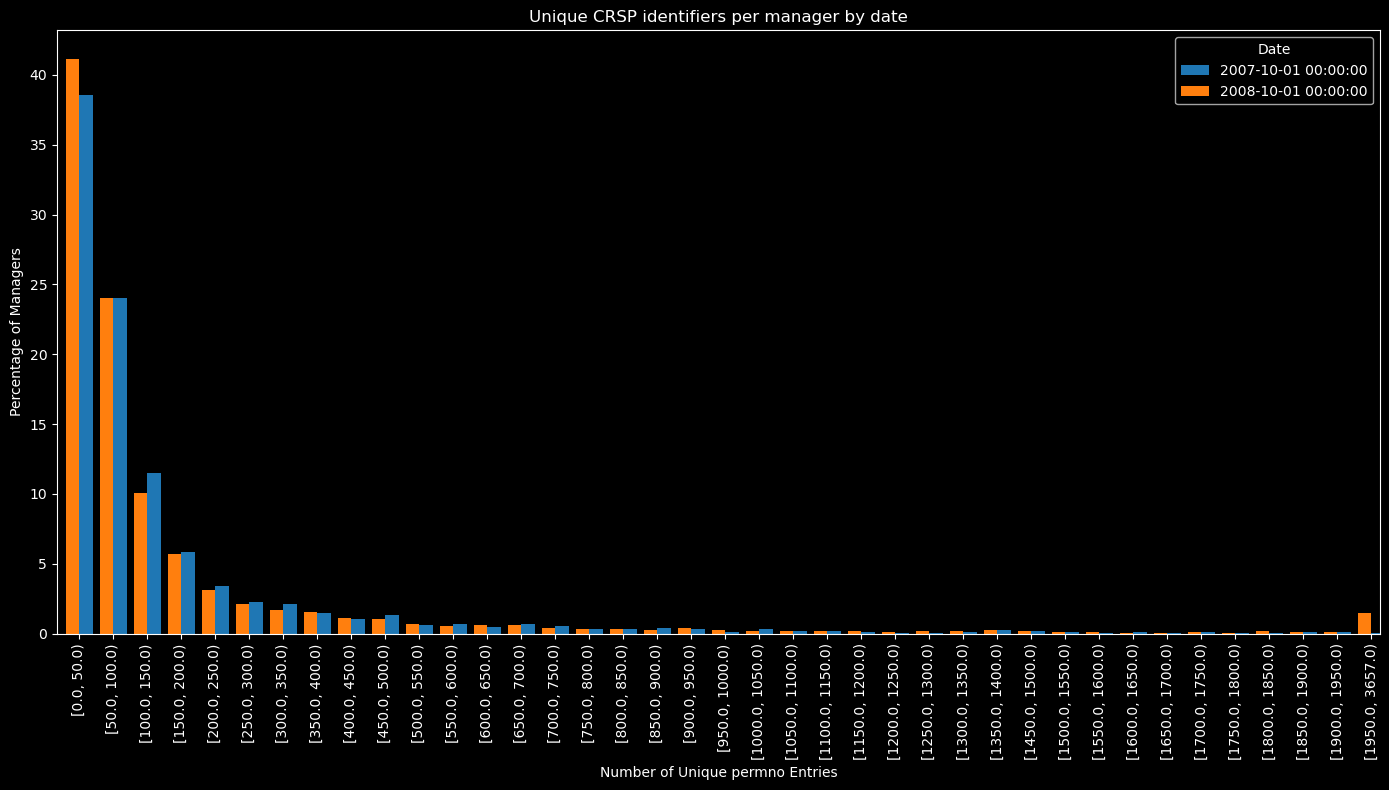

In [100]:
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.4 
colors = list(mcolors.TABLEAU_COLORS.values())
for i, (fdate, data) in enumerate(unique_permno_counts_binned_by_date.iterrows()):
  counts = data.value_counts(sort=False).sort_index()
  counts_normalized= counts / counts.sum() * 100 
  counts_normalized.plot(kind='bar', ax=ax, width=width, position=i, label=f'{fdate}', color=colors[i % len(colors)])

ax.set_xlabel('Number of Unique permno Entries')
ax.set_ylabel('Percentage of Managers')
ax.set_title('Unique CRSP identifiers per manager by date')
ax.legend(title='Date')

plt.tight_layout()
plt.show()

Regression results for 2007-10-01 00:00:00:
                                 OLS Regression Results                                
Dep. Variable:               Nholding   R-squared (uncentered):              226328.925
Model:                            OLS   Adj. R-squared (uncentered):         226412.812
Method:                 Least Squares   F-statistic:                             -2698.
Date:                Wed, 19 Feb 2025   Prob (F-statistic):                        1.00
Time:                        01:09:05   Log-Likelihood:                         -19742.
No. Observations:                2699   AIC:                                  3.949e+04
Df Residuals:                    2698   BIC:                                  3.949e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.97

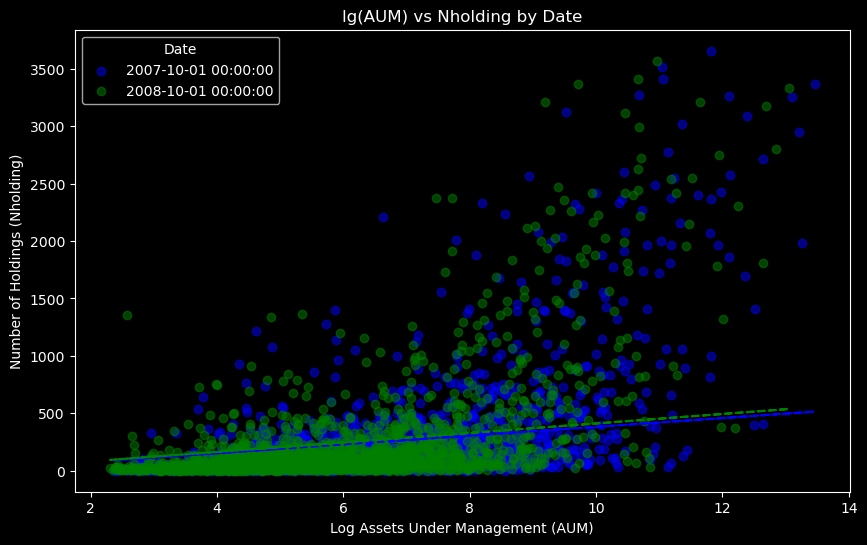

In [ ]:
unique_mgrno_fdate = df[df.mgrno != 0].drop_duplicates(subset=['mgrno', 'fdate'])
def aum_on_nholdings_coeff(date):
  data = unique_mgrno_fdate[unique_mgrno_fdate['fdate'] == date]
  X = np.log(data[['aum']])
  y = data['Nholding']
  # X = sm.add_constant(X)  # Adds a constant term to the predictor
  model = sm.OLS(y, X).fit()
  return model

unique_dates = unique_mgrno_fdate['fdate'].unique()
regression_results = {date: aum_on_nholdings_coeff(date) for date in unique_dates}

# Display results for each date
for date, model in regression_results.items():
  print(f"Regression results for {date}:")
  print(model.summary())
  print("\n")
  
# Plotting AUM vs Nholding scatter plot with different colors for each date
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

handles, labels = ax.get_legend_handles_labels()
for i, date in enumerate(unique_dates):
  date_aum = unique_mgrno_fdate[unique_mgrno_fdate['fdate'] == date]
  model = regression_results[date]
  ax.plot(np.log(date_aum['aum']), model.predict(np.log(date_aum['aum'])), color=colors[i % len(colors)], linestyle='--')
  scatter = ax.scatter(np.log(date_aum['aum']), date_aum['Nholding'], color=colors[i % len(colors)], label=str(date), alpha=0.5)
  handles.append(scatter)

ax.set_xlabel('Log Assets Under Management (AUM)')
ax.set_ylabel('Number of Holdings (Nholding)')
ax.set_title('lg(AUM) vs Nholding by Date')
ax.legend(handles=handles, title='Date')

plt.show()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.773
Model:                            OLS   Adj. R-squared (uncentered):              0.773
Method:                 Least Squares   F-statistic:                          2.779e+04
Date:                Wed, 19 Feb 2025   Prob (F-statistic):                        0.00
Time:                        01:09:05   Log-Likelihood:                          51643.
No. Observations:                8180   AIC:                                 -1.033e+05
Df Residuals:                    8179   BIC:                                 -1.033e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

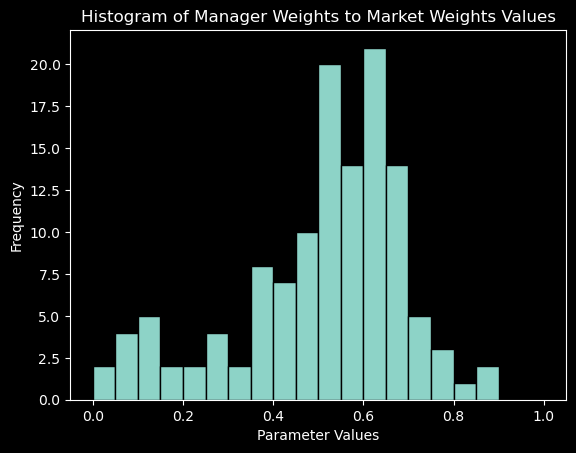

In [102]:
# Fact 3) Managers deviate from the market portfolio

average_market_weight = (df.groupby(['fdate', 'permno']).risk_asset_share.sum() / df.groupby(['fdate']).mgrno.nunique()).unstack().fillna(0)
manager_weights = df[df.Nholding > 1000].groupby(['fdate', 'permno', 'mgrno']).risk_asset_share.sum().unstack(1).fillna(0)

# Regress household weights on market weights, expect the coefficient to be close to 1 implying equal risky asset shares between households and the market
print(sm.OLS(
  average_market_weight.stack(),
  manager_weights.loc[:,0,:].stack()
).fit().summary())


# Repeat this for all managers
results = {}
for mgrno, data in manager_weights.groupby(level=1):
  y = average_market_weight.stack()
  X = data.stack().droplevel(1)
  # Ensure y and X have the same indices, in effect fixes cases where managers don't exist in a given date
  y, X = y.align(X, join='inner')
  results[mgrno] = sm.OLS(
    y,
    X
  ).fit()

params_array = np.array([result.params for result in results.values()])  
print(f"\naverage OLS coeff for market portfolio on manager portfolio: {params_array.mean() :.3f}")
print(f"average R^2 for market portfolio on manager portfolio: {np.array([result.rsquared for result in results.values()]).mean() :.3f}")

plt.hist(params_array, bins=20, range=(0, 1), edgecolor='black')
plt.xlabel('Parameter Values')
plt.ylabel('Frequency')
plt.title('Histogram of Manager Weights to Market Weights Values')
plt.show()


# 1. Institutional Portfolio Facts

### Managers Hold Concentrated Positions

We see ~65% of managers holding fewer than 100 stocks out a universe of 4090 assets. This seemingly contradicts a result that MV-optimal portfolios should span the asset universe and further diversify away idiosyncratic risk even in the case the universe is spanned.

### Number of Held Assets Scales with AUM

Building off the first fact, we see that the diminishing gains from further diversification are taken on by large AUM players. One explanation for this outside of standard models would focus on trading costs associated with odd-lots / fractional shares necessary to hold a full universe of assets. These additional costs would outweigh diversification gains for small capital bases.

### Managers Don't Hold The Market Portfolio

Taking a focused view on the managers who hold over 1000 different assets, we still find that the average risky portfolio weights deviate from the market portfolio significantly. We'd expect a given manager to hold a risky portfolio with equal weight to the market portfolio, hence a regression coeff of 1 in when regressing $ \widehat{\theta_i}$ on $\widehat{\theta_m}$. This goes against the expectations of the two-fund separation theorem.


# 2. Estimating Demand for Households and Institutions

| Variable  | Household Coeff | Institution Coeff |
| --------- | --------------- | ----------------- |
| Intercept | -13.63          | -20.23            |
| IVme      | 0.10            | 1.00              |
| LNbe      | 0.63            | 0.67              |
| profit    | -0.55           | 0.94              |
| Gat       | 0.81            | 0.62              |
| divA_be   | 11.65           | 1.72              |
| beta      | -0.09           | 0.01              |


In [ ]:
data_2007q4 = df[df['fdate'] == '2007q4']

households = data_2007q4[data_2007q4['mgrno'] == 0]
institutions = data_2007q4[data_2007q4['Nholding'] >= 1000]

# Log-linear coeffs
features = [ 'IVme', 'LNbe', 'profit', 'Gat', 'divA_be', 'beta'] # IVme instead of LNme if we want to use the instrument
target = 'LNrweight'

X_households = sm.add_constant(households[features])
y_households = households[target]

X_institutions = sm.add_constant(institutions[features])
y_institutions = institutions[target]

def objective(beta, X, y):
    """ Loss function for regression """
    predicted = X @ beta
    return np.sum((y - predicted) ** 2)

def constraint(beta):
    """ Constraint: beta_me < 1 """
    return 1 - beta[1]  # me is at i=1 (since index 0 is intercept)

beta_init = np.zeros(len(features) + 1)

result_households = minimize(
    objective, beta_init, args=(X_households, y_households),
    constraints={'type': 'ineq', 'fun': constraint}
)

result_institutions = minimize(
    objective, beta_init, args=(X_institutions, y_institutions),
    constraints={'type': 'ineq', 'fun': constraint}
)

household_params = result_households.x
institution_params = result_institutions.x

pretty_print = pd.DataFrame({
    'Variable': ['Intercept'] + features,
    'Household_Coeff': household_params,
    'Institution_Coeff': institution_params
})

pretty_print


,Variable,Household_Coeff,Institution_Coeff
0,Intercept,-13.628556,-20.230988
1,IVme,0.096657,1.000000
2,LNbe,0.631281,0.669345
3,profit,-0.553155,0.935168
4,Gat,0.806504,0.621970
5,divA_be,11.653053,1.717993
6,beta,-0.088893,0.008365


# 3. Demand Elasticities

Traditional MV portfolio choice would imply demand elasticities over 5000. Below we see institutions $\approx 0.68$ and households with higher, but reasonable demand elasticity $\approx 0.97$. Given the sensitivity to $\beta_{me}$ in the demand calculation, this seems to be on the order of magnitude previously discussed in class.


In [104]:
# we need to recover beta_me from beta_iv
# Regress LNme on IVme

X = sm.add_constant(df.dropna()['IVme'])
y = df.dropna()['LNme']
iv_model = sm.OLS(y, X).fit()

def beta_iv_to_beta_me(beta_iv):
    return beta_iv / iv_model.params['IVme']


In [105]:
beta_household = beta_iv_to_beta_me(household_params[1])  
beta_institution = beta_iv_to_beta_me(institution_params[1])

# Function to compute demand elasticity for a given investor group
def compute_demand_elasticity(data, beta_0):
    """
    Computes individual and aggregate demand elasticities for a given investor group.
    """
    investors = data['mgrno'].unique()
    
    elasticities = []

    for investor in investors:
        investor_data = data[(data['mgrno'] == investor) & (data['weight'] > 0)]
        weights = investor_data['weight']

        D_w = np.diag(weights)

        G = D_w - np.outer(weights, weights)

        elasticity_matrix = np.eye(len(weights)) - beta_0 * np.linalg.inv(D_w) @ G
        avg_elasticity = np.mean(np.diag(elasticity_matrix))

        elasticities.append(avg_elasticity)

    return np.mean(elasticities)  # Average across investors

elasticity_households = compute_demand_elasticity(households, beta_household)
elasticity_institutions = compute_demand_elasticity(institutions, beta_institution)

comparison_df = pd.DataFrame({
    "Investor Type": ["Households", "Institutions"],
    "Estimated Elasticity": [elasticity_households, elasticity_institutions],
})
comparison_df


,Investor Type,Estimated Elasticity
0,Households,0.969181
1,Institutions,0.681256


# 4. Reconciling Theoretical vs. Actual Elasticities

The traditional view in asset pricing assumes that investors quickly adjust their portfolios in response to price changes, leading to very high estimated demand elasticities (often above 5,000). However, our empirical estimates suggest much lower elasticities—around 0.97 for households and 0.68 for institutions. This suggests that in reality, investor demand is far less responsive to price changes than traditional MV-optimal portfolio predicts.

There are several plausible reasons for this discrepancy. Institutions face constraints such as index mandates, regulatory requirements, and internal risk limits that prevent them from adjusting their portfolios freely. Trading frictions like transaction costs and market impact make rebalancing costly, especially for large investors. Households behave differently than institutions, often overweighting certain stocks due to familiarity, dividend preferences, or behavioral biases that lead to sluggish portfolio adjustments. Together, these factors suggest that real-world demand is much more rigid than traditional models assume, leading to more persistent price effects when there are demand shocks.


# 5. Household Tilts vs. Institutional Investors

Going back to our findings that drive demand for an asset:

| Variable    | Household Coeff | Institution Coeff |
| ----------- | --------------- | ----------------- |
| `Intercept` | -13.63          | -20.23            |
| `IVme`      | 0.10            | 1.00              |
| `LNbe`      | 0.63            | 0.67              |
| `profit`    | -0.55           | 0.94              |
| `Gat`       | 0.81            | 0.62              |
| `divA_be`   | 11.65           | 1.72              |
| `beta`      | -0.09           | 0.01              |

We can see that most notably, households look to allocate less sensitively to price (`IVme`). We can also see a bias away from profitability for households and towards growth relative to institutional investors. Lastly, dividend payments drive strong household demand via `divA_be`


# 6. Additional Characteristics for Asset Demand Models

Shifting ESG priorities, including their rise over the past 20 years and recent signs of pullback, could influence investor demand as preferences change. Past performance and volatility, with investors reacting to different time lags, might also shape demand. Media coverage could drive attention-based buying, causing short-term price shifts.

In a global market, factors like economic exposure, exchange rates, and legal systems could play a big role in shaping demand. Differences in tax policies, investment restrictions, and local regulations may lead investors in different countries to value the same assets differently. These factors help explain why demand doesn’t always follow traditional risk-return models.
